# Advanced Machine Learning
## Project 1 - Logistic Regression with Cyclic Coordinate Descent

---

Binda Michal, Kutak Wojciech, Legczylin Michail

## Task 1

In [3]:
import os
import numpy as np
import openml
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

DATA_PATH = "../data/"  # Path to save the datasets
os.makedirs(DATA_PATH, exist_ok=True)

dataset_ids = [1137, 1158, 46611, 45088]

# Function to prepare and evaluate each dataset
def evaluate__preprocess_dataset(dataset_id):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    original_num_features = X.shape[1]

    # Fill missing values with the mean for numerical columns
    X = X.fillna(X.mean())

    # Encode target variable if it's categorical
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = LabelEncoder().fit_transform(y)
        print("First 5 elements of the encoded target:", y[:5])

    # Remove collinear variables (correlation threshold: 0.9)
    correlation_matrix = X.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    collinear_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    X = X.drop(columns=collinear_features)

    # Evaluate dataset based on criteria
    num_observations = X.shape[0]
    num_features = X.shape[1]
    is_binary = pd.Series(y).nunique() == 2  # Fixed line
    are_features_numerical = X.select_dtypes(include='number').shape[1] == num_features
    feature_observation_ratio = num_features / num_observations
    meets_ratio_requirement = feature_observation_ratio >= 0.5

    # Print evaluation results
    print(f"Dataset ID: {dataset_id}")
    print(f"Name: {dataset.name}")
    print(f"Number of Observations: {num_observations}")
    print(f"Number of Features: {original_num_features}")
    print(f"Binary Classification: {'Yes' if is_binary else 'No'}")
    print(f"All Features Numerical: {'Yes' if are_features_numerical else 'No'}")
    print(f"Feature/Observation Ratio: {feature_observation_ratio:.2f} ({'Meets Requirement' if meets_ratio_requirement else 'Does Not Meet Requirement'})")
    print(f"Number of Features after preprocessing: {X.shape[1]}")
    # print(f"Removed Collinear Features: {len(collinear_features)}")
    print("-" * 50)

    return X, y




In [4]:
# Evaluate each dataset
for dataset_id in dataset_ids:
    print(f"Processing dataset {dataset_id}")
    ds_path = os.path.join(DATA_PATH, str(dataset_id)+".csv")
    X, y = evaluate__preprocess_dataset(dataset_id)
    ds = pd.concat([X, pd.DataFrame({"target": y})], axis=1)
    ds.to_csv(ds_path)
    print(f"Finished processing {dataset_id}")
    print("-" * 50)

Processing dataset 1137
First 5 elements of the encoded target: [1 1 1 1 1]
Dataset ID: 1137
Name: AP_Colon_Kidney
Number of Observations: 546
Number of Features: 10935
Binary Classification: Yes
All Features Numerical: Yes
Feature/Observation Ratio: 17.49 (Meets Requirement)
Number of Features after preprocessing: 9548
--------------------------------------------------
Finished processing 1137
--------------------------------------------------
Processing dataset 1158
First 5 elements of the encoded target: [0 0 0 0 0]
Dataset ID: 1158
Name: AP_Breast_Kidney
Number of Observations: 604
Number of Features: 10935
Binary Classification: Yes
All Features Numerical: Yes
Feature/Observation Ratio: 15.73 (Meets Requirement)
Number of Features after preprocessing: 9501
--------------------------------------------------
Finished processing 1158
--------------------------------------------------
Processing dataset 46611
First 5 elements of the encoded target: [0 0 0 0 0]
Dataset ID: 46611
Name: 

In [4]:
import os
import numpy as np
import pandas as pd

DATA_PATH = "../data"

def generate_synthetic_data(p, n, d, g):
    # Generate binary class labels Y from Bernoulli distribution
    ones_count = np.random.binomial(n, p)
    zeros_count = n - ones_count

    # Create covariance matrix S
    s = np.arange(0, d)
    ones_vector = np.ones((d,))
    S = np.zeros((d, d))
    for i in range(d):
        S[i, :] = g ** np.abs(s)
        s = s - ones_vector

    # Generate feature vectors X
    mean = np.array([1 / (j + 1) for j in range(d)])
    X_0 = np.random.multivariate_normal(mean=np.zeros(d), cov=S, size=zeros_count)
    X_1 = np.random.multivariate_normal(mean=mean, cov=S, size=ones_count)

    X = np.concat([X_0, X_1], axis=0)
    y = np.concat([np.zeros((zeros_count,)), np.ones((ones_count,))])

    # Shuffle randomly X and y
    idx = np.arange(n)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    return pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(d)]), pd.Series(y, name="Target")


## Task 2

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import norm

from implementation.LogRegCCD import LogRegCCD
from implementation.measures import Measure

np.random.seed(666)

In [3]:
# ?LogRegCCD
print(LogRegCCD.__doc__)


Logistic Regression classifier using cyclic coordinate descend optimization method.

This class implements regularized logistic regression with Elastic-Net penalty.

Parameters
----------    
C : float, default=None
    Inverse of regularization strength; must be a positive float.
    Like in support vector machines, smaller values specify stronger
    regularization.

alpha : float, default=1.0
    The Elastic-Net mixing parameter, with ``0 <= alpha <= 1``.
    Setting ``alpha=0`` is equivalent to having ridge regularization (L2),
    while setting ``alpha=1`` is equivalent to having lasso
    regularization (L1). For ``0 < alpha <1``, the penalty is a
    combination of L1 and L2.

Attributes
----------
beta_ : ndarray of shape (n_features, )
    Coefficient of the features in the decision function.

beta0_ : float
    Intercept (a.k.a. bias) added to the decision function.

    If `fit_intercept` is set to False, the intercept is set to zero.



In [4]:
# ?LogRegCCD.fit
print(LogRegCCD.fit.__doc__)


Fit the model according to the given training data.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    Training vector, where `n_samples` is the number of samples and
    `n_features` is the number of features.

y : array-like of shape (n_samples,)
    Target vector relative to X.

max_iter : int, default=100
    Maximum number of iterations taken for the solvers to converge.

use_weights: bool, default=True
    Specifies if method should use weights optimization.
    If `use_weights` is False, then each sample is given unit weight.

fit_intercept : bool, default=True
    Specifies if a constant (a.k.a. bias or intercept) should be
    added to the decision function.

plot_coefficients : bool, default=False
    If True plots how coefficients update based on iteration of algorithm.

Returns
-------
self
    Fitted estimator.



In [5]:
n = 1000
p = 3

In [6]:
beta0 = 0.5
beta = np.ones(p)

In [8]:
X = np.random.multivariate_normal(np.zeros(p), np.diag(np.ones(p)), n)
probs = norm.cdf(beta0 + X @ beta)
y = np.random.binomial(1, probs)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.25)

In [10]:
print(X_train.shape)
X_train[:10]

(600, 3)


array([[-1.47196877, -2.0657038 , -1.68120057],
       [-0.40775071, -1.23978688, -0.81372068],
       [ 0.50173696,  0.63984185,  0.19554728],
       [ 1.36125179,  0.85173059,  1.19763669],
       [ 0.83873261,  0.83201859,  1.16251043],
       [ 1.46394938, -0.52591744,  0.28668635],
       [ 0.42703454, -0.35997841,  0.25287036],
       [ 1.37042402, -1.03991663,  1.30319165],
       [-0.37056164,  0.82755745,  0.69559213],
       [ 1.7758585 ,  0.91126353, -2.19931889]])

In [11]:
print(y_train.shape)
y_train[:10]

(600,)


array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [12]:
print(X_valid.shape)
X_valid[:10]

(300, 3)


array([[ 0.63604988,  0.11400229, -0.70594164],
       [-0.6633509 , -0.69650521, -0.54629675],
       [-0.22728938,  2.27423443, -1.71722164],
       [ 2.18173819, -1.26319337,  0.00546737],
       [ 0.0925478 ,  1.1177675 , -1.10457442],
       [ 0.85592135, -0.16253923,  1.15680737],
       [ 0.39201433, -0.46721079,  1.63506346],
       [-1.11705041, -0.47626511,  0.95816923],
       [-0.9630923 ,  1.79864553, -0.84029642],
       [ 1.73085145,  0.98379989,  0.63158696]])

In [13]:
print(y_valid.shape)
y_valid[:10]

(300,)


array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1])

In [14]:
print(X_test.shape)
X_test[:10]

(100, 3)


array([[-0.86146623,  1.20299912, -0.80944449],
       [-2.78657387, -0.58483218, -0.4098337 ],
       [ 1.0956535 ,  0.34138417,  0.2285505 ],
       [-0.10634854,  0.31801884, -0.29653081],
       [-0.90101539, -0.75407247, -0.72297369],
       [-0.02372813, -0.06731833,  0.517025  ],
       [ 0.92977607,  1.22877676,  0.36974431],
       [-1.05503414,  0.40579669, -0.94585884],
       [-0.45444769, -0.13417476,  2.01094449],
       [-0.35410835,  0.27764982,  1.00238358]])

In [15]:
print(y_test.shape)
y_test[:10]

(100,)


array([0, 0, 1, 1, 0, 0, 1, 0, 0, 1])

In [16]:
model1 = LogRegCCD().fit(X_train, y_train)

In [17]:
print(model1.beta0_, *model1.beta_)

0.34333332700115804 0.1833972327766556 0.1893043498029538 0.1986752680289114


In [18]:
accuracy_score(y_valid, model1.predict(X_valid))

0.7133333333333334

In [19]:
model2 = LogisticRegression().fit(X_train, y_train)

In [20]:
print(model2.intercept_, *model2.coef_)

[0.80584325] [1.61339858 1.64894993 1.55947447]


In [21]:
accuracy_score(y_valid, model2.predict(X_valid))

0.8466666666666667

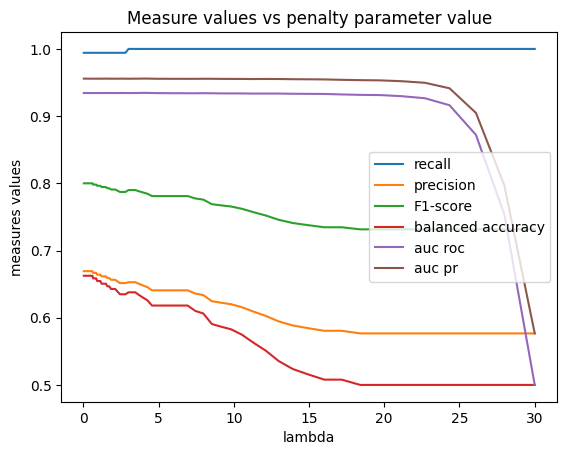

In [22]:
LogRegCCD.plot(X_train, y_train, X_valid, y_valid, list(Measure.Type))

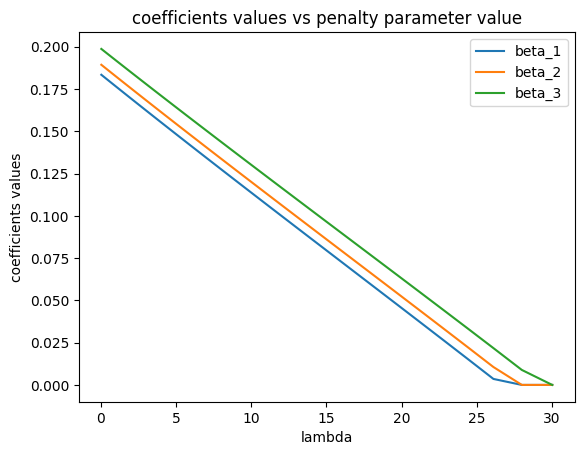

In [23]:
LogRegCCD.plot_coefficients(X_train, y_train)

In [24]:
model3 = LogRegCCD(lambda_=0).fit(X_train, y_train)

In [25]:
print(model3.beta0_, *model3.beta_)

0.34333332700115804 0.1836068168748295 0.1895126794160436 0.19888096712224596


In [26]:
accuracy_score(y_valid, model3.predict(X_valid))

0.7133333333333334

In [27]:
model4 = LogisticRegression(penalty=None).fit(X_train, y_train)

In [28]:
print(model4.intercept_, *model4.coef_)

[0.84276489] [1.70357966 1.74397547 1.64313306]


In [29]:
accuracy_score(y_valid, model4.predict(X_valid))

0.8466666666666667

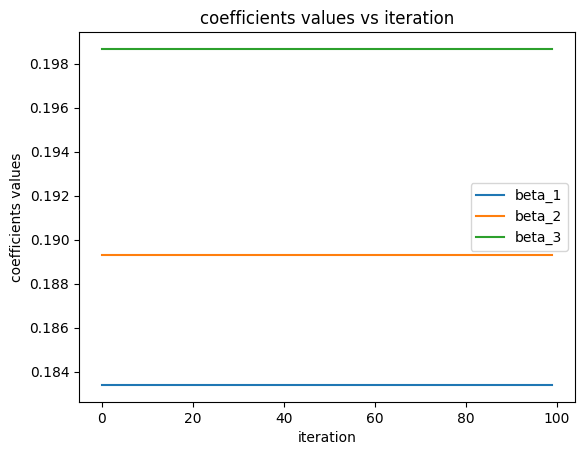

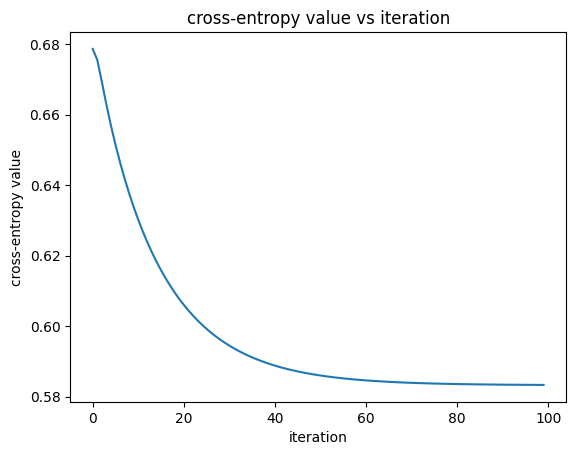

In [30]:
LogRegCCD().fit(X_train, y_train, plot_coefficients=True)

## Task 3

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, average_precision_score, \
    f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

sys.path.append("../Task2")
sys.path.append("../Task1")

from implementation.LogRegCCD import LogRegCCD
from synthetic_dataset import generate_synthetic_data

seed = 42
np.random.seed(seed)
random.seed(seed)

DATA_PATH = "../data/"

## Synthetic dataset
---

In [2]:
def compute_metrics_synthetic(model, X_train, y_train, X_test, y_test):
    """
    Computes the ROC AUC and balanced accuracy score for synthetic data.

    Parameters:
    ----------
    model: The model to use for prediction.
    X_train (numpy.ndarray): Training feature matrix.
    y_train (numpy.ndarray): Training target vector.
    X_test (numpy.ndarray): Testing feature matrix.
    y_test (numpy.ndarray): Testing target vector.

    Returns:
    ----------
    roc_auc (float): ROC AUC score.
    balanced_acc (float): Balanced accuracy score.
    """

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)
    roc_auc = roc_auc_score(y_test, y_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    return roc_auc, balanced_acc

#### 1. Balanced vs unbalanced datasets

Check how ROC and Balanced accuracy looks like. 

How harder is it to classify class $Y=1$ than $Y=0$ when there is a small number of samples per class?

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/qg/gflj6rgd0wj20kdyzmh7j73r0000gn/T/ipykernel_36069/2409694650.py:8: SyntaxWarning: invalid escape sequence '\l'
  legend = [f"LogRegCCD $\lambda=${l:.2f}" for l in Lambdas]


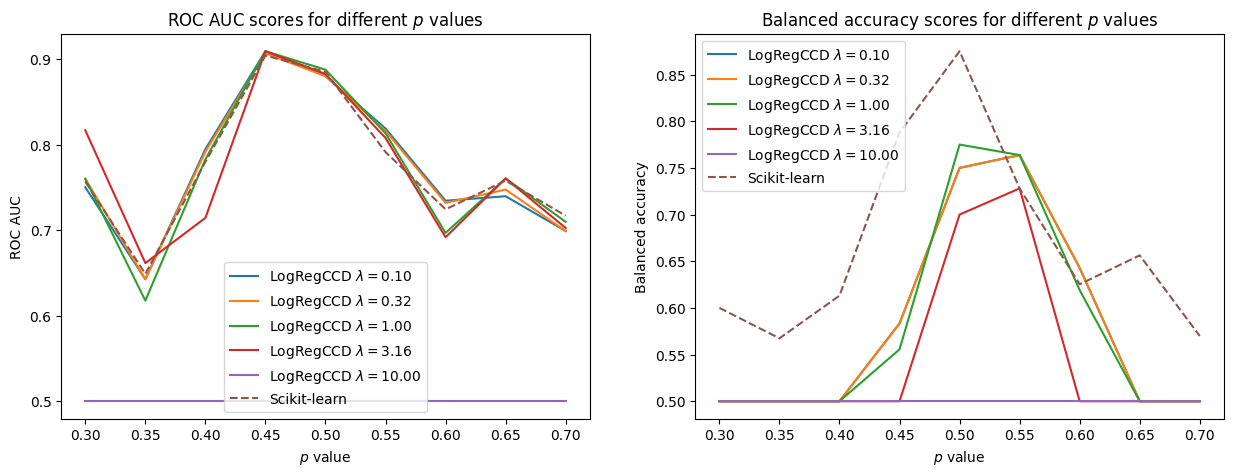

In [3]:
# Parameters for synthetic data generation
P = np.linspace(0.3, 0.7, 9, dtype=np.float32)
Lambdas = np.logspace(-1, 1, 5)
g = 0.2
d = 5
n = 200

legend = [f"LogRegCCD $\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(1, 2, figsize=(15, 5))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for idx, p in enumerate(P):
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []

    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(C=1/l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(1, 2, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different $p$ values")
plt.ylabel("ROC AUC")
plt.xlabel("$p$ value")
plt.xticks(range(len(P)), [f"{p:.2f}" for p in P])
plt.legend(legend)

plt.subplot(1, 2, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different $p$ values")
plt.ylabel("Balanced accuracy")
plt.xlabel("$p$ value")
plt.xticks(range(len(P)), [f"{p:.2f}" for p in P])
plt.legend(legend)


plt.show()

#### 2. Overall small cardinality

Given that datasets are balanced, I suspect that the classification results are much worse for 
highly correlated data.

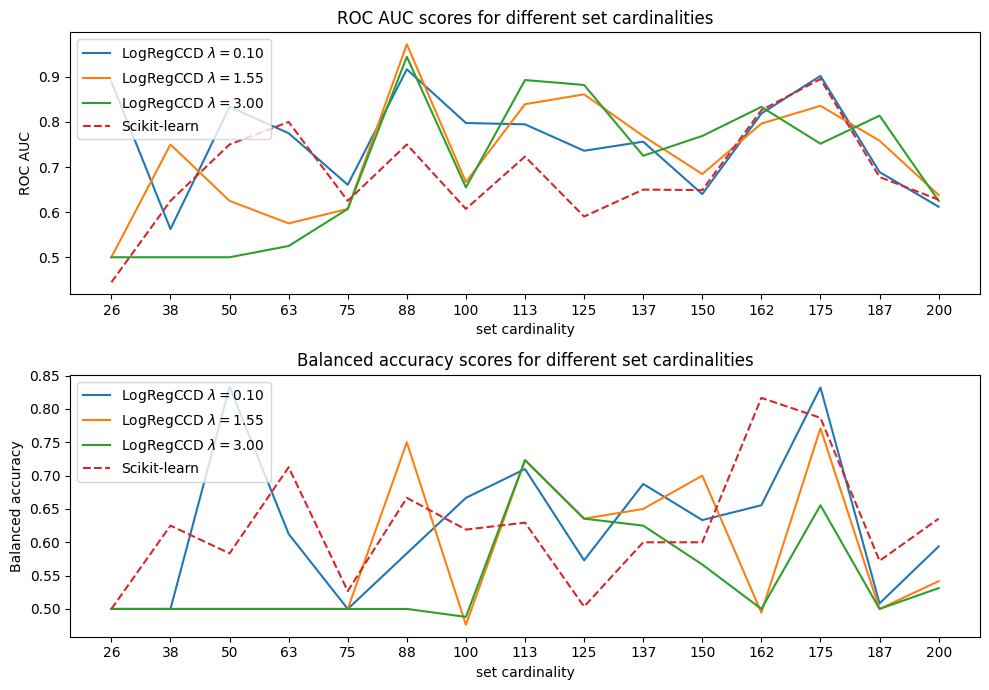

In [ ]:
p = 0.5
Lambdas = np.linspace(0.1, 3, 3)
g = 0.2
d = 25
N = np.linspace(26, 200, 15, dtype=np.int32)

legend = [f"LogRegCCD $\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for n in N:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(C=1/l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different set cardinalities")
plt.ylabel("ROC AUC")
plt.xlabel("set cardinality")
plt.xticks(range(len(N)), N)
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different set cardinalities")
plt.ylabel("Balanced accuracy")
plt.xlabel("set cardinality")
plt.xticks(range(len(N)), N)
plt.legend(legend)
plt.tight_layout()

plt.show()

### 3. Dimensionality

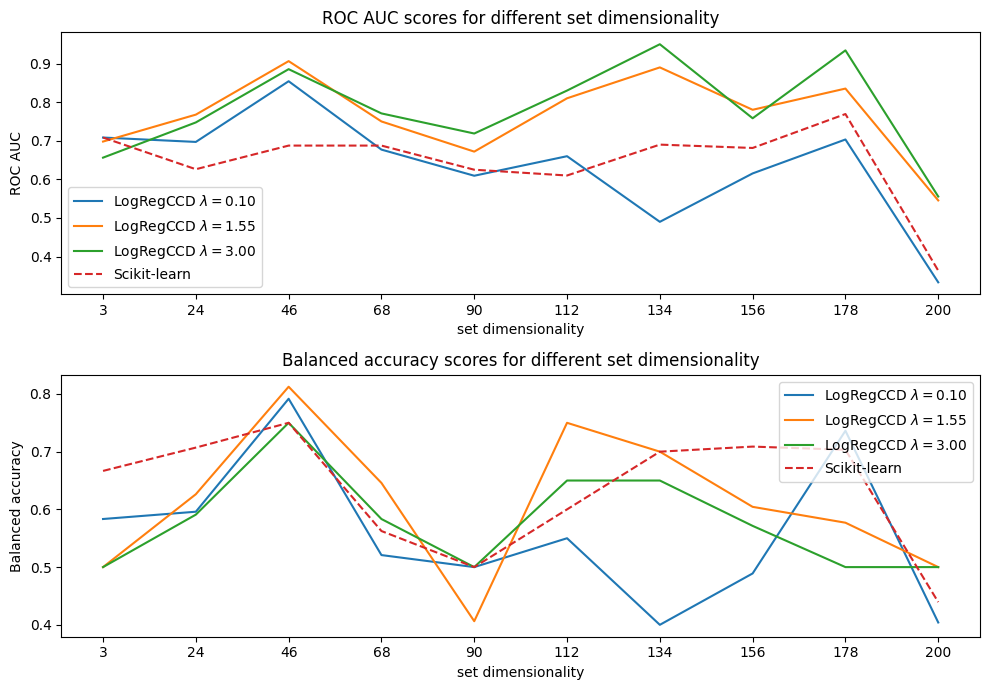

In [ ]:
p = 0.5
Lambdas = np.linspace(0.1, 3, 3)
g = 0.0
D = np.linspace(3, 200, 10, dtype=int)
n = 100

legend = [f"LogRegCCD $\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for d in D:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(C=1/l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different set dimensionality")
plt.ylabel("ROC AUC")
plt.xlabel("set dimensionality")
plt.xticks(range(len(D)), D)
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different set dimensionality")
plt.ylabel("Balanced accuracy")
plt.xlabel("set dimensionality")
plt.xticks(range(len(D)), D)
plt.legend(legend)
plt.tight_layout()

plt.show()

### 4. Correlation

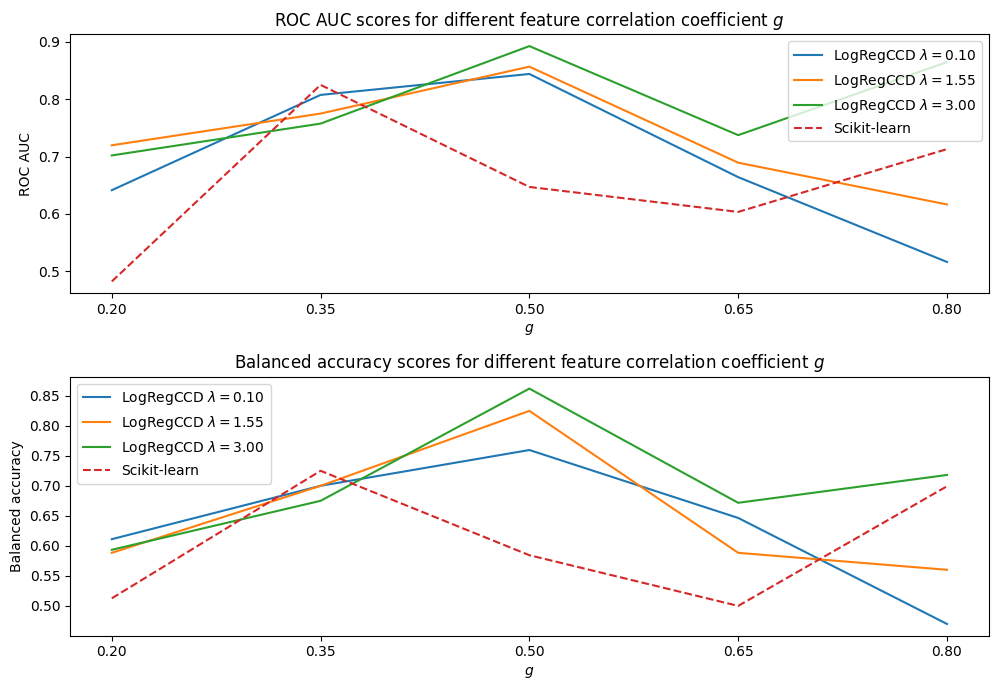

In [ ]:
p = 0.5
Lambdas = np.linspace(0.1, 3, 3)
G = np.linspace(0.2, 0.8, 5)
d = 100
n = 200

legend = [f"LogRegCCD $\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for g in G:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(C=1/l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different feature correlation coefficient $g$")
plt.ylabel("ROC AUC")
plt.xlabel("$g$")
plt.xticks(range(len(G)), [f"{g:.2f}" for g in G])
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different feature correlation coefficient $g$")
plt.ylabel("Balanced accuracy")
plt.xlabel("$g$")
plt.xticks(range(len(G)), [f"{g:.2f}" for g in G])
plt.legend(legend)
plt.tight_layout()

plt.show()

## Comparing real-world datasets
---

In [ ]:
def plot_roc_curve(y_test, y_proba, label, **kwargs):
    """
    Plot ROC curve and compute AUC score.

    Parameters:
    ----------
    y_test (numpy.ndarray): True labels for the test set.
    y_proba (numpy.ndarray): Predicted probabilities for the positive class.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    roc_auc (float): AUC score.
    """

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=label +f" (AUC = {roc_auc:.2f})", **kwargs)
    return roc_auc

def plot_precision_recall_curve(y_test, y_proba, label, **kwargs):
    """
    Plot precision-recall curve and compute average precision score.

    Parameters:
    ----------
    y_test (numpy.ndarray): True labels for the test set.
    y_proba (numpy.ndarray): Predicted probabilities for the positive class.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    avg_precision (float): Average precision score.
    """

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=label + f" (AUC = {avg_precision:.2f})", **kwargs)
    return avg_precision

def compute_metrics(model, X_train, y_train, X_test, y_test, label, **kwargs):
    """
    Computes the ROC AUC and balanced accuracy score for a given model.

    Parameters:
    ----------
    model: The model to use for prediction.
    X_train (numpy.ndarray): Training feature matrix.
    y_train (numpy.ndarray): Training target vector.
    X_test (numpy.ndarray): Testing feature matrix.
    y_test (numpy.ndarray): Testing target vector.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    roc_auc (float): ROC AUC score.
    balanced_acc (float): Balanced accuracy score.
    avg_precision (float): Average precision score.
    f1 (float): F1 score.
    """

    # Fit the model
    model.fit(X_train, y_train)
    # Predict probabilities
    y_proba = model.predict_proba(X_test)

    # Check if y_proba is 2D and take the second column (probability of class 1)
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)

    # Compute metrics
    roc_auc = plot_roc_curve(y_test, y_proba, label, **kwargs)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    avg_precision = plot_precision_recall_curve(y_test, y_proba, label, **kwargs)
    f1 = f1_score(y_test, y_pred)
    return roc_auc, balanced_acc, avg_precision, f1

In [239]:
def process_dataset(dataset_file, title, lambdas, seed=42):
    """
    Process a dataset and compute metrics using LogRegCCD and Scikit-learn.

    Parameters:
    ----------
    dataset_file (str): Path to the dataset file.
    title (str): Title for the dataset.
    lambdas (list | None): List of lambda values for LogRegCCD. If None, lambdas will be estimated
        by LogRegCCD.
    seed (int): Random seed for reproducibility.
    """
    print(f"Processing dataset: {dataset_file} ({title})")

    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Load the dataset
    df = pd.read_csv(os.path.join(DATA_PATH, dataset_file))
    print("Number of observations: ", df.shape[0])
    print("Number of features: ", df.shape[1])
    print("Number of classes: ", df.iloc[:, -1].nunique())
    print("Class distribution: ", df.iloc[:, -1].value_counts())
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    # Scale the features
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    if lambdas is None:
        C = [None]
        legend = ["LogRegCCD", "Scikit-learn"]
    else:
        C = [1/l for l in lambdas]
        legend = [f"LogRegCCD $\lambda=${l:.1e}" for l in lambdas]
        legend.append("Scikit-learn")

    plt.subplots(2, 2, figsize=(16, 10))

    roc_scores = []
    bal_acc_scores = []
    avg_precision_scores = []
    f1_scores = []
    intercepts = []
    coefficients = []

    # Compute metrics for LogRegCCD
    for c in C:
        ccd = LogRegCCD(C=c)
        roc_auc, bal_acc, avg_precision, f1 = compute_metrics(ccd, X_train, y_train,
                                                              X_test, y_test,
                                                              label=f"LogRegCCD"
                                                              + (f" $\lambda=${(1/c):.1e}"
                                                                 if c is not None else ""))
        roc_scores.append(roc_auc)
        bal_acc_scores.append(bal_acc)
        avg_precision_scores.append(avg_precision)
        f1_scores.append(f1)
        coefficients.append(ccd.beta_)
        intercepts.append(ccd.beta0_)

    # Compute metrics for Scikit-learn
    lr_sk = LogisticRegression(penalty=None)
    sk_roc_auc, sk_bal_acc, sk_avg_precision, sk_f1 = compute_metrics(lr_sk, X_train, y_train,
                                                          X_test, y_test,
                                                          label=f"Scikit-learn",
                                                          linestyle="--")

    roc_scores.append(sk_roc_auc)
    bal_acc_scores.append(sk_bal_acc)
    avg_precision_scores.append(sk_avg_precision)
    f1_scores.append(sk_f1)
    coefficients.append(lr_sk.coef_[0])
    intercepts.append(lr_sk.intercept_[0])

    plt.subplot(2, 2, 1)
    plt.title(f"ROC curve for {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title(f"Precision-recall curve for {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    # Bar plot for Balanced Accuracy scores
    plt.subplot(2, 2, 3)
    bars = plt.bar(range(len(bal_acc_scores)), bal_acc_scores, tick_label=legend, color='skyblue')
    plt.title(f"Balanced Accuracy Scores for {title}")
    plt.ylabel("Balanced Accuracy")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")

    # Bar plot for F1 scores
    plt.subplot(2, 2, 4)
    bars = plt.bar(range(len(f1_scores)), f1_scores, tick_label=legend, color='lightgreen')
    plt.title(f"F1 Scores for {title}")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")
    plt.show()

    # Plot coefficients and intercepts
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.boxplot(coefficients, vert=True, patch_artist=True, tick_labels=legend, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot of Coefficients for {title}")
    plt.xlabel("Model")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(intercepts)), intercepts, tick_label=legend, color='pink')
    plt.title(f"Intercepts for {title}")
    plt.ylabel("Intercept Value")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")
    plt.show()

    print("Coefficient statstics:")
    for i, coefs in enumerate(coefficients):
        print(f"\t{legend[i]}: mean={np.mean(coefs):.2f}, std={np.std(coefs):.2f}"
              f", min={np.min(coefs):.2f}, max={np.max(coefs):.2f}")
    print("Intercepts:")
    for i, intercept in enumerate(intercepts):
        print(f"\t{legend[i]}: {intercept:.2f}")

Processing dataset: 45088.csv (DLBCL)
Number of observations:  77
Number of features:  5199
Number of classes:  2
Class distribution:  target
0    58
1    19
Name: count, dtype: int64


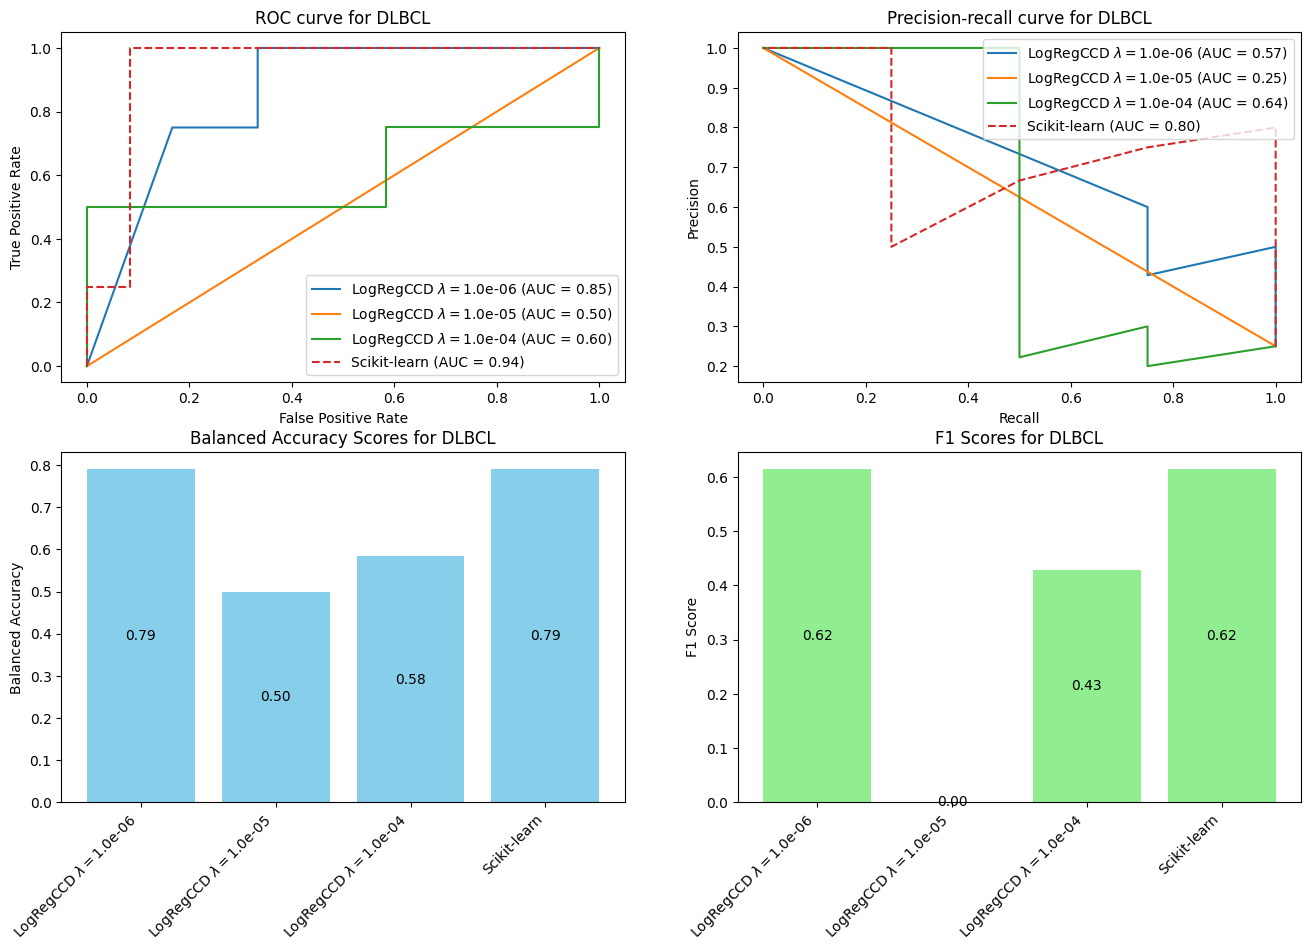

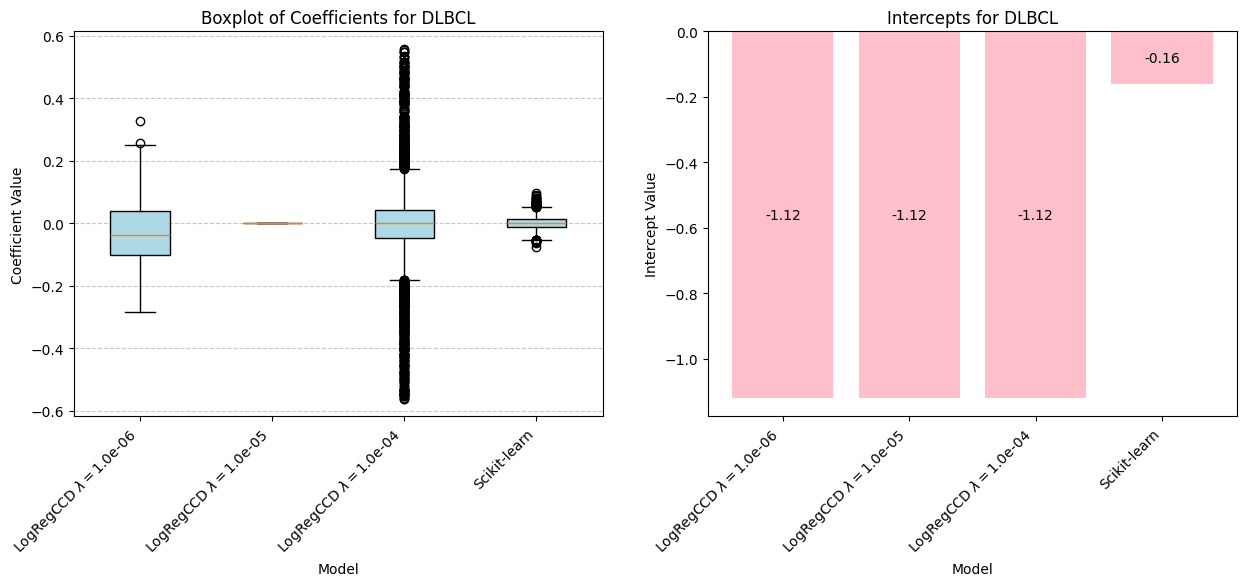

Coefficient statstics:
	LogRegCCD $\lambda=$1.0e-06: mean=-0.03, std=0.09, min=-0.28, max=0.33
	LogRegCCD $\lambda=$1.0e-05: mean=0.00, std=0.00, min=-0.00, max=-0.00
	LogRegCCD $\lambda=$1.0e-04: mean=-0.00, std=0.13, min=-0.56, max=0.56
	Scikit-learn: mean=0.00, std=0.02, min=-0.08, max=0.10
Intercepts:
	LogRegCCD $\lambda=$1.0e-06: -1.12
	LogRegCCD $\lambda=$1.0e-05: -1.12
	LogRegCCD $\lambda=$1.0e-04: -1.12
	Scikit-learn: -0.16


In [ ]:
# Process DLBCL dataset
# The DLBCL dataset is a gene expression dataset for Diffuse Large B-cell Lymphoma (DLBCL).

seed = 37
lambdas = np.logspace(-6, -4, 3)
process_dataset("45088.csv", "DLBCL", lambdas, seed=seed)

Processing dataset: ../data/46611.csv (Toxicity)
Number of observations:  171
Number of features:  479
Number of classes:  2
Class distribution:  target
0    115
1     56
Name: count, dtype: int64


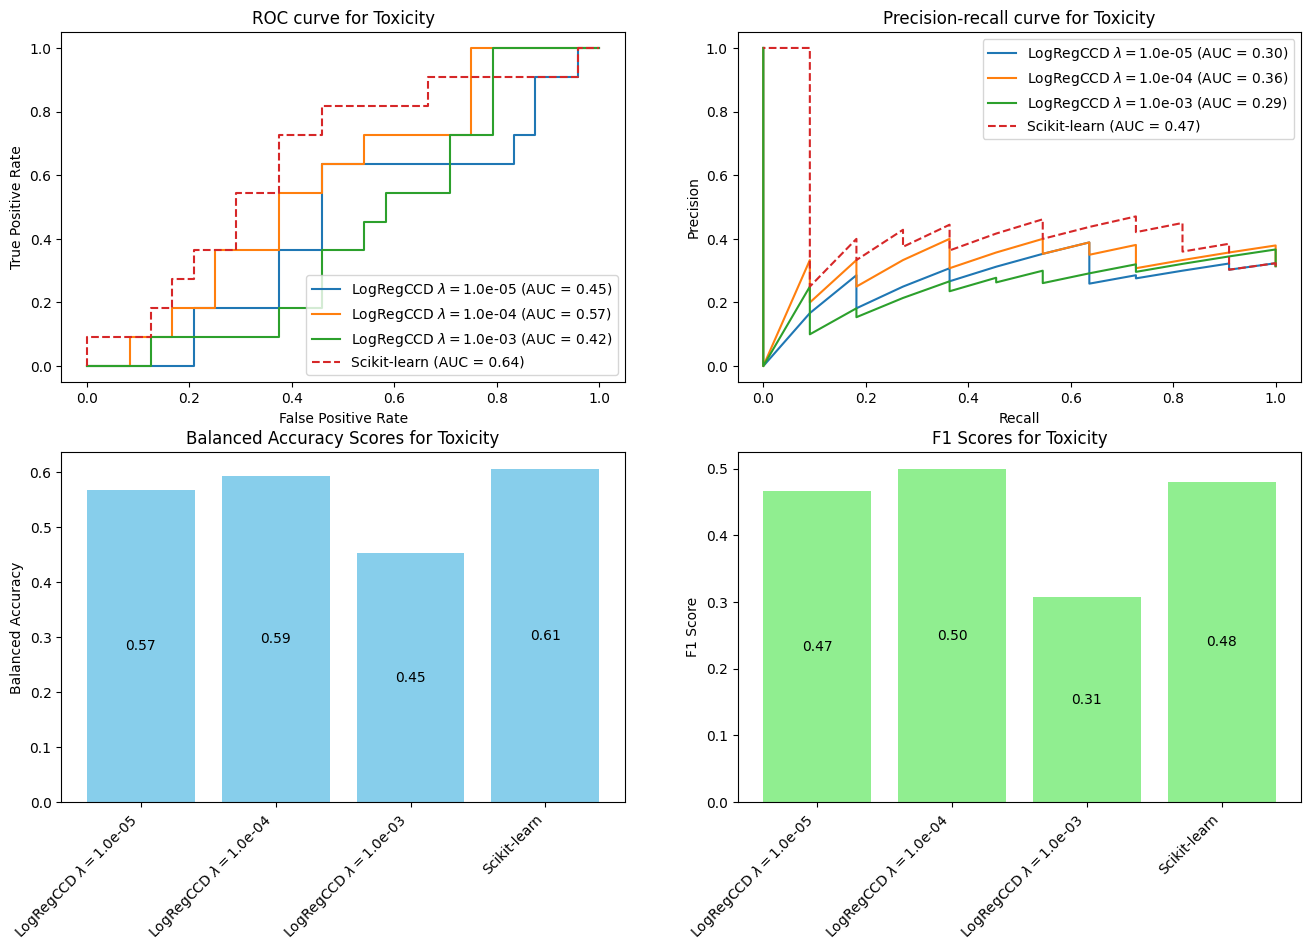

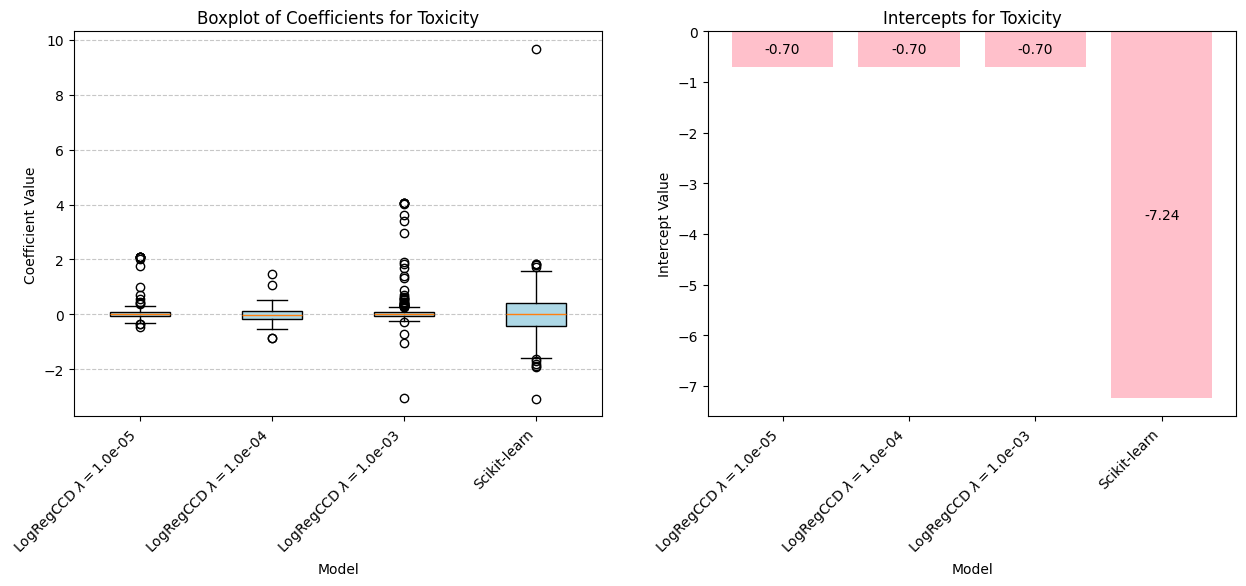

Coefficient statstics:
	LogRegCCD $\lambda=$1.0e-05: mean=0.04, std=0.30, min=-0.47, max=2.08
	LogRegCCD $\lambda=$1.0e-04: mean=-0.04, std=0.22, min=-0.87, max=1.48
	LogRegCCD $\lambda=$1.0e-03: mean=0.09, std=0.55, min=-3.03, max=4.05
	Scikit-learn: mean=0.01, std=0.81, min=-3.09, max=9.67
Intercepts:
	LogRegCCD $\lambda=$1.0e-05: -0.70
	LogRegCCD $\lambda=$1.0e-04: -0.70
	LogRegCCD $\lambda=$1.0e-03: -0.70
	Scikit-learn: -7.24


In [ ]:
# Process Toxicity dataset
# The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1,
# responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic.

seed = 42
lambdas = np.logspace(-5, -3, 3)
process_dataset(DATA_PATH + "46611.csv", "Toxicity", lambdas, seed=seed)

Processing dataset: 1137.csv (AP Colon-Kidney)
Number of observations:  546
Number of features:  9550
Number of classes:  2
Class distribution:  target
0    286
1    260
Name: count, dtype: int64


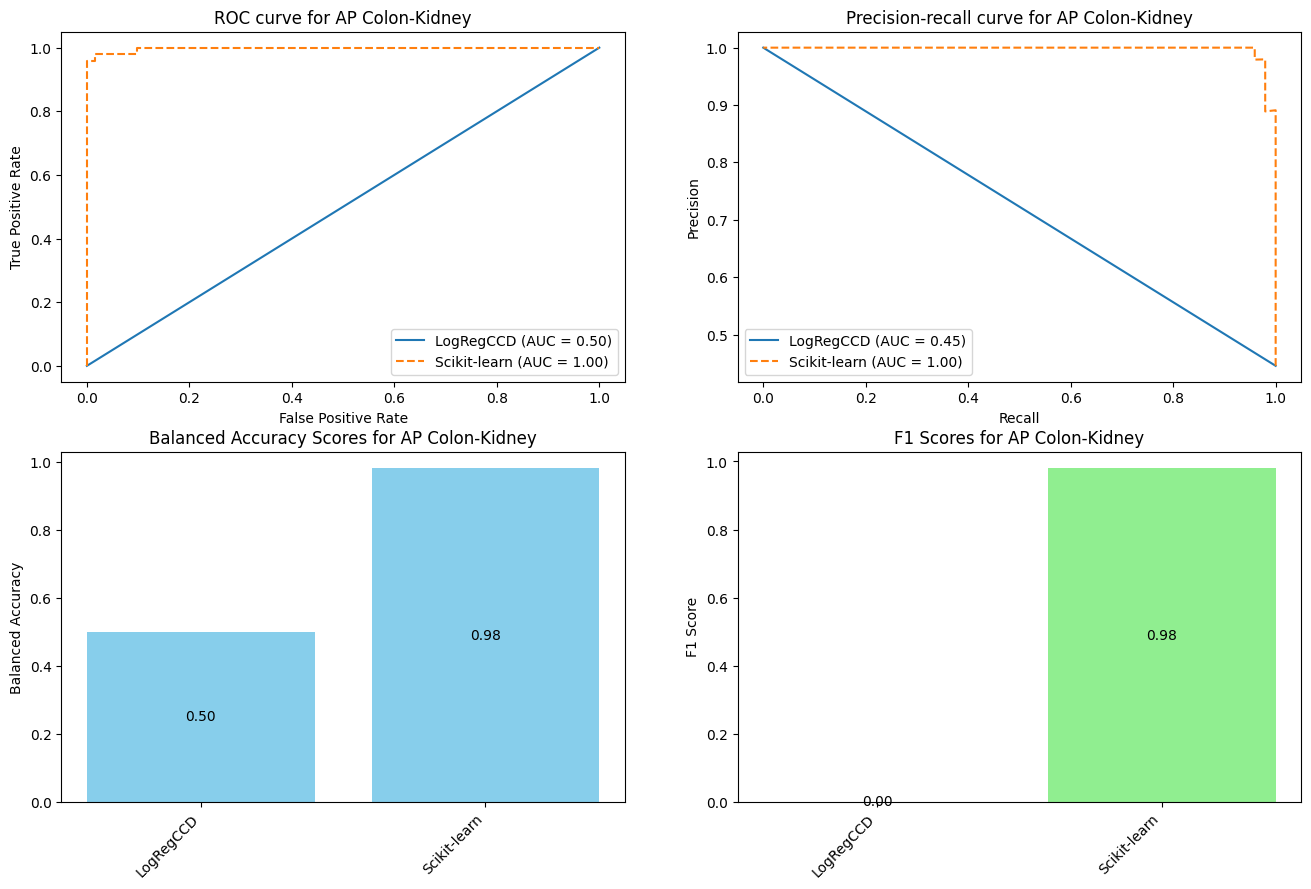

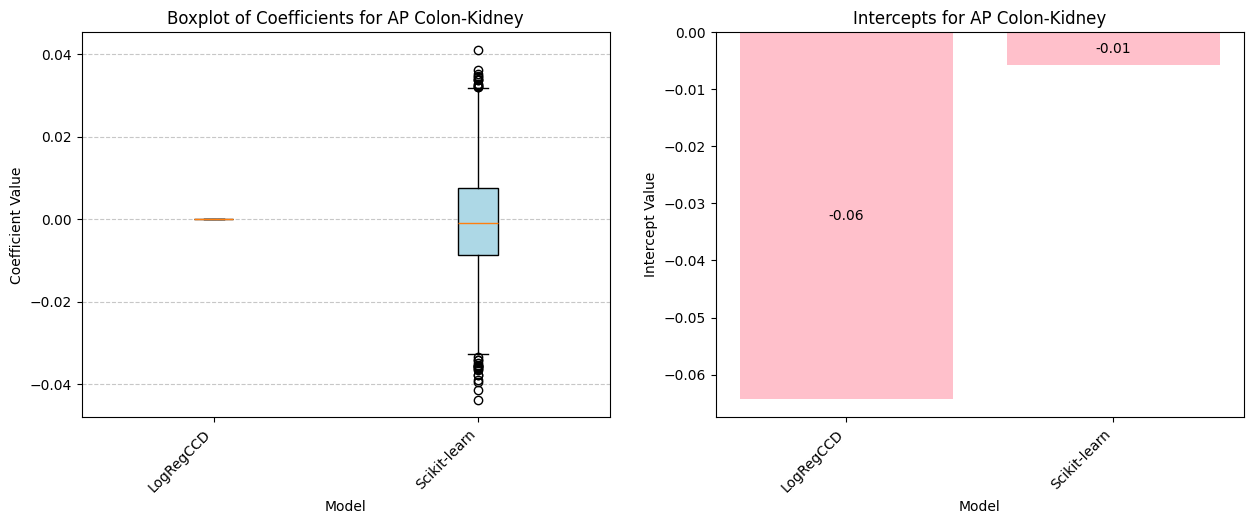

Coefficient statstics:
	LogRegCCD: mean=0.00, std=0.00, min=0.00, max=0.00
	Scikit-learn: mean=-0.00, std=0.01, min=-0.04, max=0.04
Intercepts:
	LogRegCCD: -0.06
	Scikit-learn: -0.01


In [ ]:
# Process Colon-Kidney dataset

seed = 42
process_dataset("1137.csv", "AP Colon-Kidney", None, seed=seed)

Processing dataset: 1158.csv (AP Breast-Kidney)
Number of observations:  604
Number of features:  9503
Number of classes:  2
Class distribution:  target
0    344
1    260
Name: count, dtype: int64


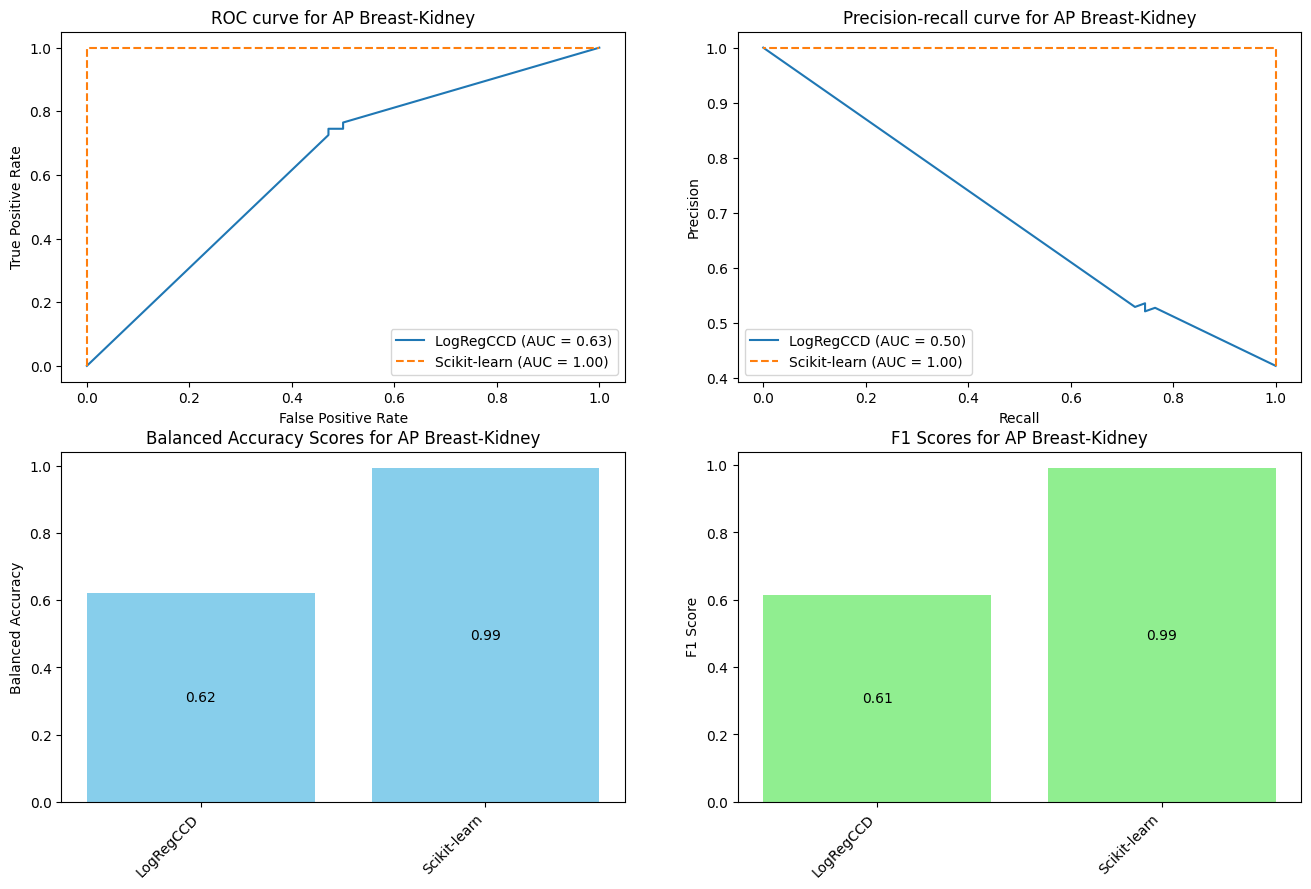

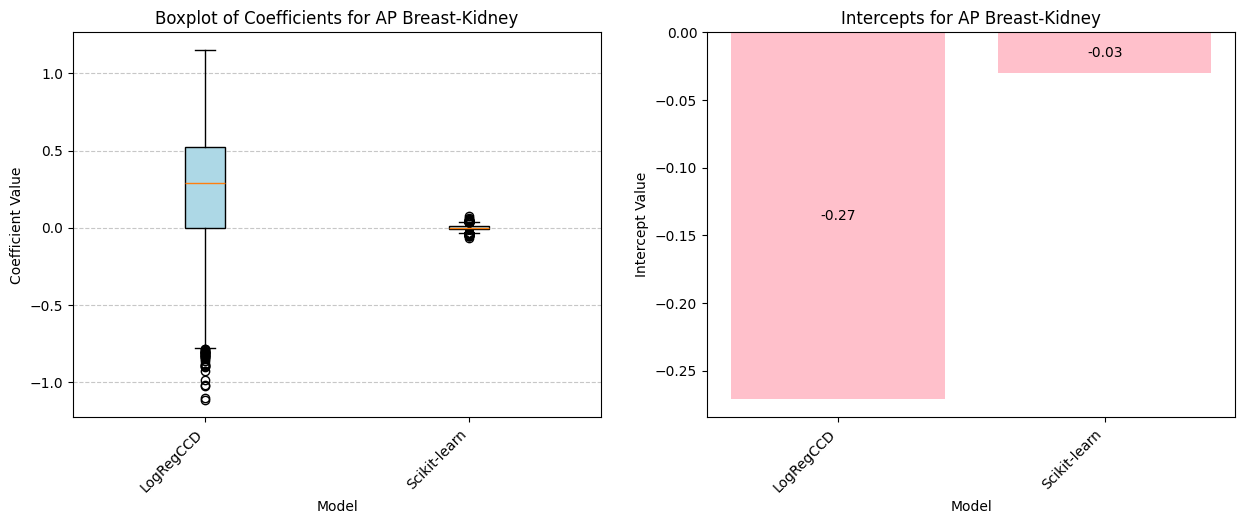

Coefficient statstics:
	LogRegCCD: mean=0.23, std=0.38, min=-1.11, max=1.15
	Scikit-learn: mean=0.00, std=0.01, min=-0.07, max=0.08
Intercepts:
	LogRegCCD: -0.27
	Scikit-learn: -0.03


In [ ]:
# Process Breast-Kidney dataset

seed = 42
process_dataset("1158.csv", "AP Breast-Kidney", None, seed=seed)